In [90]:
#Import dependencies
#Import data
#Preprocess for random forest model
#Scale data
#Bucket employment growth rate for prediction
#Instantiate, fit model, run predictions
#Measure accuracy

In [91]:
#Import dependencies
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from datetime import datetime
#import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#display options
pd.set_option ('display.max_rows', 10)


In [92]:
#Set path of input file
file_path = "Resources/Cleaned_Data.csv"
#Read input file into a DataFrame
ratings_df = pd.read_csv(file_path)
ratings_df

,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,...,% Not Proficient in English,% Female,% Rural,Employed 2015,Employed 2020,Employment Growth Rate,Primary Care Physicians Ratio,Dentist Ratio,Mental Health Provider Ratio,Other Primary Care Provider Ratio
0,1001,Alabama,Autauga,791.0,8129.0,21,4.7,4.7,9.0,18,...,1,51.4,42.0,23986.0,24580.0,2.476445,2220.0,3089.0,4277.0,2527.0
1,1003,Alabama,Baldwin,2967.0,7354.0,18,4.2,4.3,8.0,17,...,1,51.5,42.3,85953.0,98768.0,14.909311,1372.0,2019.0,1038.0,1787.0
2,1005,Alabama,Barbour,472.0,10254.0,30,5.4,5.2,11.0,22,...,2,47.2,67.8,8597.0,8707.0,1.279516,3159.0,2765.0,12441.0,1914.0
3,1007,Alabama,Bibb,471.0,11978.0,19,4.6,4.6,10.0,19,...,0,46.8,68.4,8294.0,8303.0,0.108512,2061.0,4480.0,4480.0,896.0
4,1009,Alabama,Blount,1085.0,11335.0,22,4.9,4.9,8.0,19,...,2,50.7,90.0,22189.0,22836.0,2.915859,4463.0,5258.0,6427.0,4449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,Wyoming,Sweetwater,532.0,7832.0,15,3.4,3.6,10.0,18,...,2,48.5,10.9,23010.0,21572.0,-6.249457,2721.0,1872.0,395.0,1485.0
3138,56039,Wyoming,Teton,109.0,2731.0,12,3.0,3.2,8.0,15,...,4,48.4,46.4,14298.0,14909.0,4.273325,862.0,1154.0,210.0,923.0
3139,56041,Wyoming,Uinta,256.0,7331.0,16,3.6,3.7,10.0,17,...,1,49.3,43.1,10064.0,9710.0,-3.517488,2277.0,1128.0,282.0,1561.0
3140,56043,Wyoming,Washakie,110.0,6586.0,16,3.6,3.7,7.0,17,...,0,49.4,36.0,3892.0,3841.0,-1.310380,2016.0,1314.0,254.0,1971.0


In [93]:
#inspect data to see which fields are strings that need to be converted to numeric
ratings_df.select_dtypes(include=['object']).columns

Index(['State', 'County'], dtype='object')

In [94]:
#State we can get_dummies for, and county is already represented by the FIPS code (which is the unique
#key which won't contribute information anyway) so it can be dropped

preprocessed_df = ratings_df
preprocessed_df.drop(columns=['County'],inplace=True)
preprocessed_df

,FIPS,State,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,...,% Not Proficient in English,% Female,% Rural,Employed 2015,Employed 2020,Employment Growth Rate,Primary Care Physicians Ratio,Dentist Ratio,Mental Health Provider Ratio,Other Primary Care Provider Ratio
0,1001,Alabama,791.0,8129.0,21,4.7,4.7,9.0,18,33,...,1,51.4,42.0,23986.0,24580.0,2.476445,2220.0,3089.0,4277.0,2527.0
1,1003,Alabama,2967.0,7354.0,18,4.2,4.3,8.0,17,31,...,1,51.5,42.3,85953.0,98768.0,14.909311,1372.0,2019.0,1038.0,1787.0
2,1005,Alabama,472.0,10254.0,30,5.4,5.2,11.0,22,42,...,2,47.2,67.8,8597.0,8707.0,1.279516,3159.0,2765.0,12441.0,1914.0
3,1007,Alabama,471.0,11978.0,19,4.6,4.6,10.0,19,38,...,0,46.8,68.4,8294.0,8303.0,0.108512,2061.0,4480.0,4480.0,896.0
4,1009,Alabama,1085.0,11335.0,22,4.9,4.9,8.0,19,34,...,2,50.7,90.0,22189.0,22836.0,2.915859,4463.0,5258.0,6427.0,4449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,Wyoming,532.0,7832.0,15,3.4,3.6,10.0,18,30,...,2,48.5,10.9,23010.0,21572.0,-6.249457,2721.0,1872.0,395.0,1485.0
3138,56039,Wyoming,109.0,2731.0,12,3.0,3.2,8.0,15,12,...,4,48.4,46.4,14298.0,14909.0,4.273325,862.0,1154.0,210.0,923.0
3139,56041,Wyoming,256.0,7331.0,16,3.6,3.7,10.0,17,36,...,1,49.3,43.1,10064.0,9710.0,-3.517488,2277.0,1128.0,282.0,1561.0
3140,56043,Wyoming,110.0,6586.0,16,3.6,3.7,7.0,17,29,...,0,49.4,36.0,3892.0,3841.0,-1.310380,2016.0,1314.0,254.0,1971.0


In [95]:
#Get dummies for State field
df_binary_encoded = pd.get_dummies(preprocessed_df, columns=['State'])
df_binary_encoded.describe()

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,...,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,30383.649268,1334.757810,8582.946648,17.930617,3.990643,4.167696,8.146293,17.466900,32.901655,7.451361,...,0.021006,0.030236,0.080840,0.009230,0.004456,0.042330,0.012412,0.017505,0.022915,0.007320
std,15162.508374,3189.377652,2480.245236,4.746985,0.705693,0.602053,2.024920,3.626552,5.456978,1.141906,...,0.143426,0.171262,0.272633,0.095643,0.066613,0.201372,0.110735,0.131163,0.149657,0.085258
min,1001.000000,32.000000,2731.000000,8.000000,2.400000,2.500000,3.000000,6.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18177.500000,245.000000,6910.500000,14.000000,3.500000,3.700000,7.000000,15.000000,29.000000,6.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29176.000000,547.000000,8582.946648,17.000000,3.900000,4.200000,8.000000,17.000000,33.000000,7.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45080.500000,1334.757810,9917.250000,21.000000,4.400000,4.600000,9.000000,20.000000,37.000000,8.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,56045.000000,84296.000000,29138.000000,41.000000,7.100000,6.300000,24.000000,41.000000,58.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
#Bin employment growth rate to use for prediction
#Examine it again
df_binary_encoded['Employment Growth Rate'].describe()

count    3142.000000
mean        2.965745
std         8.904445
min       -41.604676
25%        -1.962408
50%         2.700750
75%         7.456576
max       109.410007
Name: Employment Growth Rate, dtype: float64

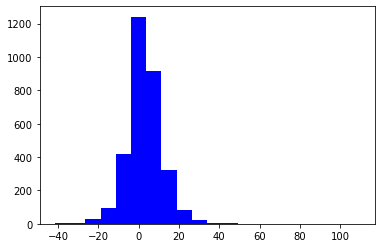

In [97]:
# Look at the distribution of values for employment growth rate
num_bins = 20
n,bins,patches = plt.hist(df_binary_encoded['Employment Growth Rate'],num_bins, facecolor = 'blue')
plt.show()
#Looks fairly normal/bell shaped


In [98]:
#Make employment growth rate bands of 2.5%
#Create a function to calculate growth level and apply to column
def rate_bands(rate):
    max_band_threshold = 110
    band_size = 2.5
    max_band = int(max_band_threshold/band_size)
    if rate < max_band_threshold:
        rate_band = int(rate / band_size)
    else:
        rate_band = max_band
    return rate_band

In [99]:
df_binary_encoded['Employment Growth Band'] = df_binary_encoded['Employment Growth Rate'].apply(rate_bands)
df_binary_encoded.head()

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Employment Growth Band
0,1001,791.0,8129.0,21,4.7,4.7,9.0,18,33,7.2,...,0,0,0,0,0,0,0,0,0,0
1,1003,2967.0,7354.0,18,4.2,4.3,8.0,17,31,8.0,...,0,0,0,0,0,0,0,0,0,5
2,1005,472.0,10254.0,30,5.4,5.2,11.0,22,42,5.6,...,0,0,0,0,0,0,0,0,0,0
3,1007,471.0,11978.0,19,4.6,4.6,10.0,19,38,7.8,...,0,0,0,0,0,0,0,0,0,0
4,1009,1085.0,11335.0,22,4.9,4.9,8.0,19,34,8.4,...,0,0,0,0,0,0,0,0,0,1


In [100]:
pd.set_option ('display.max_rows', None)
df_binary_encoded['Employment Growth Band'].value_counts()

 0     815
 1     476
 2     359
-1     276
 3     243
 4     175
-2     172
 5     136
-3     102
 6      77
 7      51
-4      51
 8      40
-6      33
-5      33
 9      19
-7      15
 10     13
-8      11
 12     10
-9       9
 11      6
 13      3
 18      2
-16      2
-11      2
 15      1
-14      1
 14      1
 43      1
 21      1
-10      1
 16      1
-15      1
-12      1
 22      1
 29      1
Name: Employment Growth Band, dtype: int64

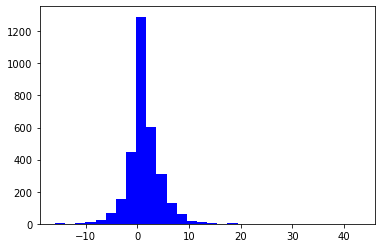

In [101]:
# 6. Look at the distribution of values for employment growth rate
num_bins = 30
n,bins,patches = plt.hist(df_binary_encoded['Employment Growth Band'],num_bins, facecolor = 'blue')
plt.show()
#Looks fairly normal/bell shaped

In [102]:
#Set features and target values
#features
X = df_binary_encoded.drop(columns=['Employment Growth Rate','Employment Growth Band','FIPS'])
#target values
y = df_binary_encoded['Employment Growth Band']

In [103]:
#Throw all the lowest into their own bucket and all the highest into their own bucket to get rid of groups 
#with only one member which crashes the model
#So -10 and lower together and 12 and greater together
df_binary_encoded['Employment Growth Band'] = np.where(df_binary_encoded["Employment Growth Band"]>=12,12,df_binary_encoded["Employment Growth Band"])
df_binary_encoded['Employment Growth Band'] = np.where(df_binary_encoded["Employment Growth Band"]<=-10,-10,df_binary_encoded["Employment Growth Band"])

In [104]:
pd.set_option ('display.max_rows', None)
df_binary_encoded['Employment Growth Band'].value_counts()

 0     815
 1     476
 2     359
-1     276
 3     243
 4     175
-2     172
 5     136
-3     102
 6      77
-4      51
 7      51
 8      40
-5      33
-6      33
 12     22
 9      19
-7      15
 10     13
-8      11
-9       9
-10      8
 11      6
Name: Employment Growth Band, dtype: int64

In [105]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [106]:
from sklearn.metrics import accuracy_score
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.268


Text(0.5, 1.0, 'Random Forest Model Feature Importances')

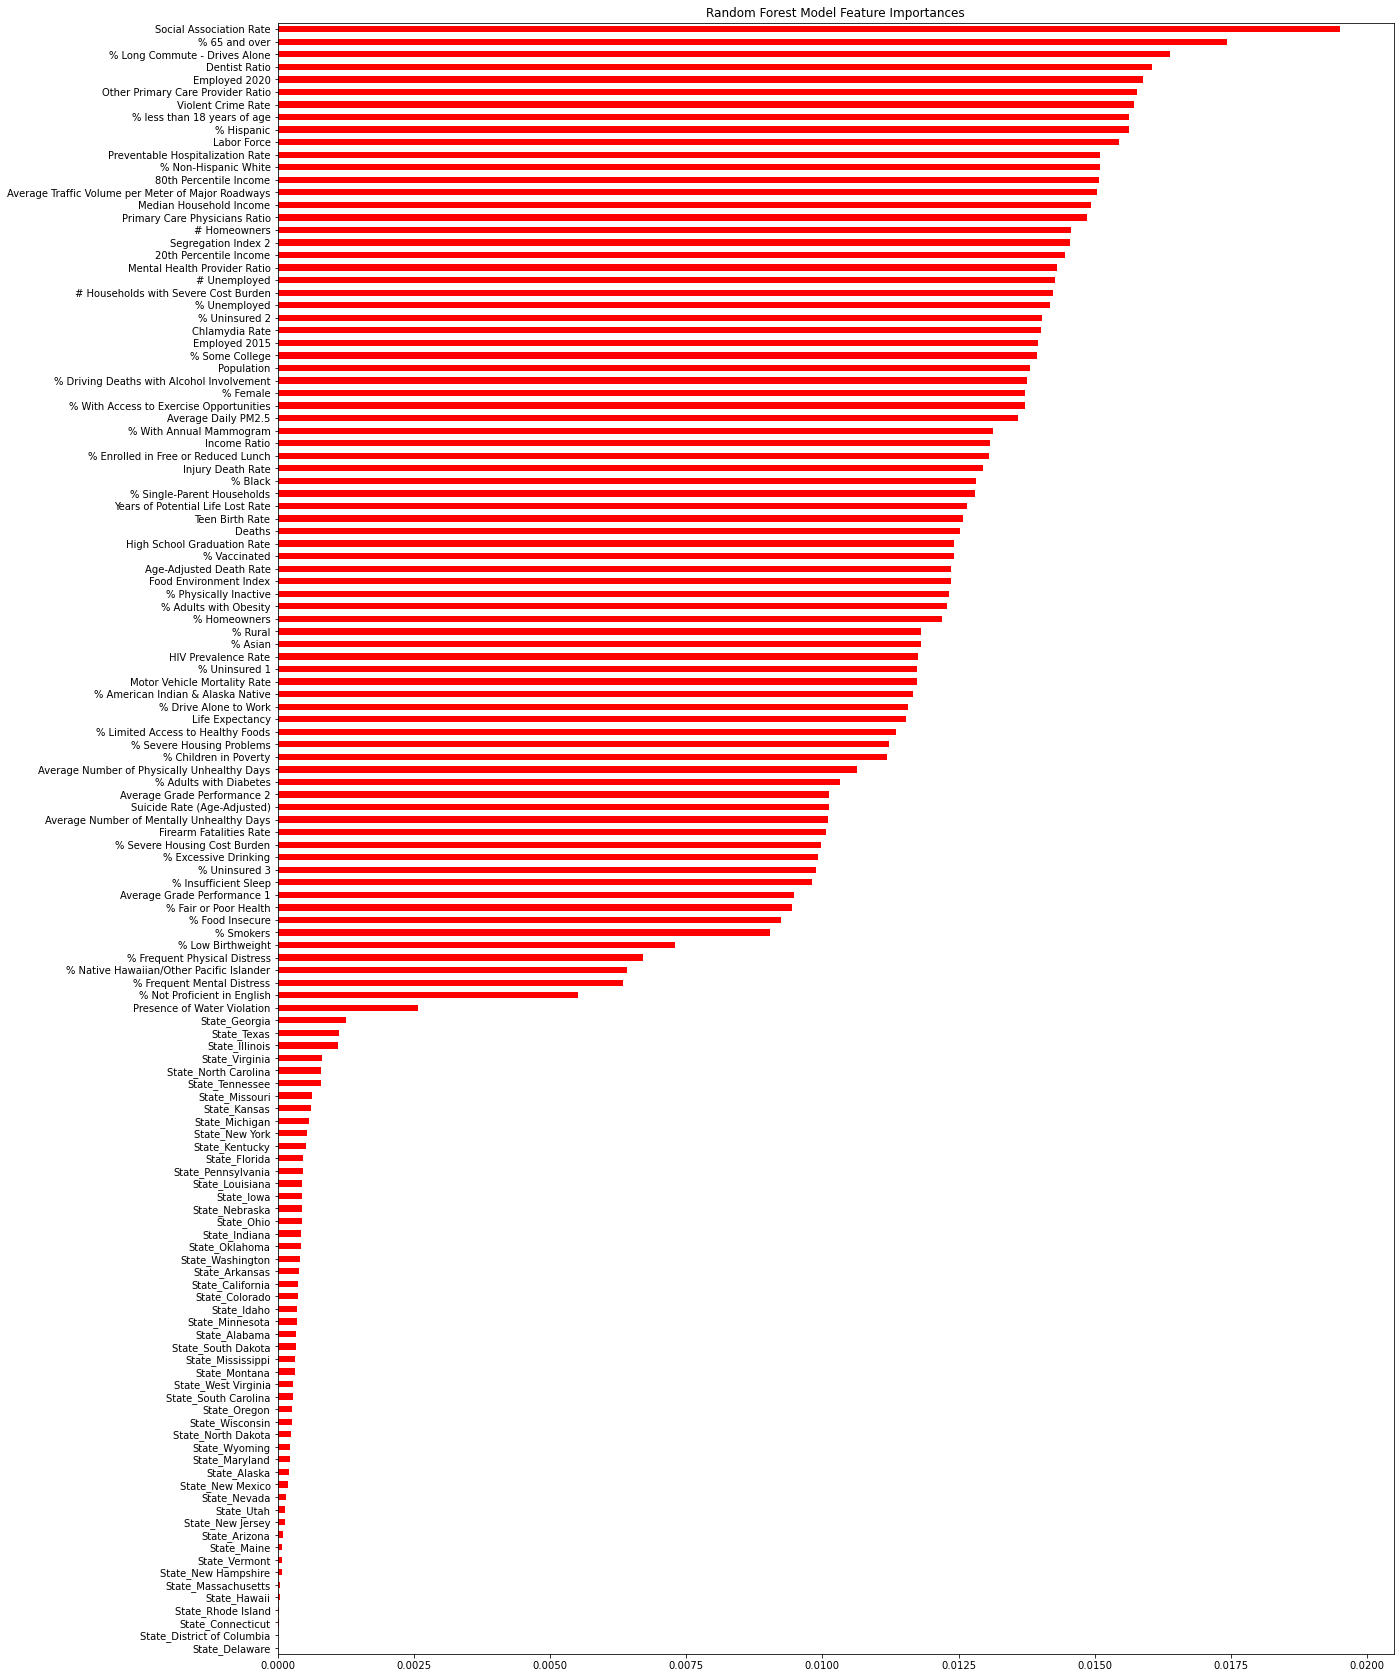

In [107]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances
columns = X_train.columns
rfGraph = pd.Series(importances, columns)
from matplotlib.pyplot import figure
figure(figsize=(20,30))
rfGraph.sort_values().plot.barh(color="red")
plt.title("Random Forest Model Feature Importances")